In [3]:
import pandas as pd
import pandahouse
import swifter #Ускоряет метод apply
import hashlib #Делает хеши
import seaborn as sns
from scipy import stats #Статистика
import numpy as np
from random import sample
import numpy as np
from scipy.stats import ttest_ind
from typing import List

In [4]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

In [5]:
 q = """
    select user_id,
           exp_group,
           countIf(action='like') as likes,
           countIf(action='view') as views,
           likes / views as ctr
    from {db}.feed_actions
    where toDate(time) >= '2023-06-23' and toDate(time) <= '2023-06-29'
    and exp_group in (2, 3)
    group by exp_group, user_id
    """

In [6]:
 df_aa = pandahouse.read_clickhouse(q, connection=connection)

In [7]:
 # датафрейм для A/A теста с ctr для каждого пользователя
df_aa

,user_id,exp_group,likes,views,ctr
0,115383,3,38,248,0.153226
1,10326,3,24,132,0.181818
2,123580,3,25,122,0.204918
3,131473,2,19,98,0.193878
4,23985,2,12,44,0.272727
...,...,...,...,...,...
16782,122008,3,20,123,0.162602
16783,25383,2,2,18,0.111111
16784,122190,3,15,56,0.267857
16785,108927,2,16,51,0.313725


In [8]:
 # проверим группы на размеры
df_aa.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


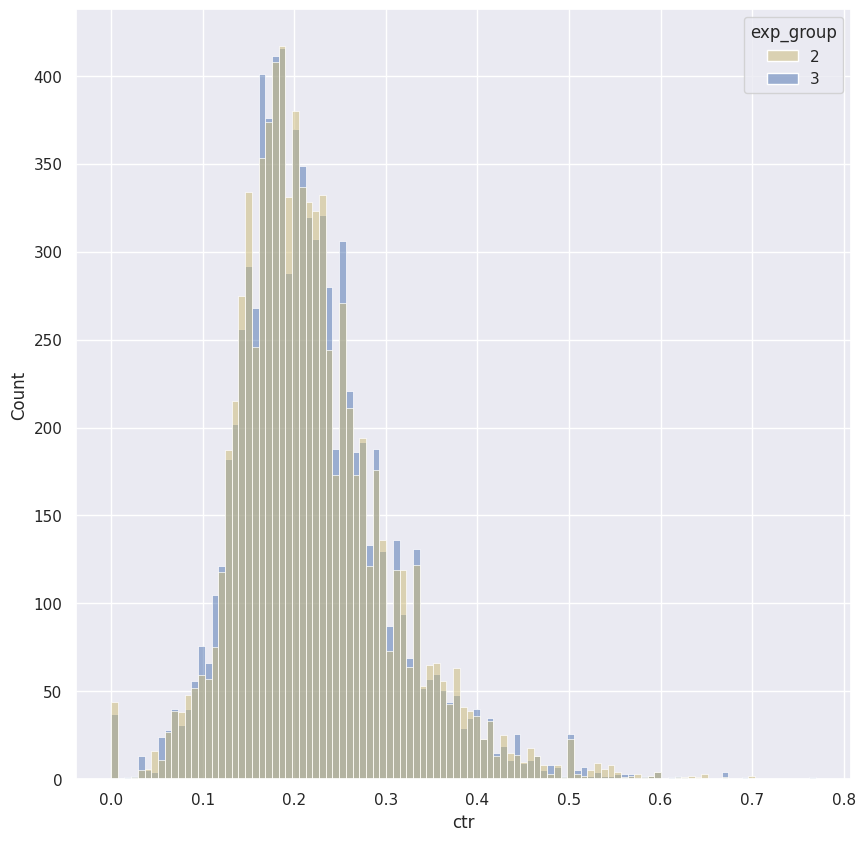

In [9]:
# Установим размер графиков
sns.set(rc={'figure.figsize':(10, 10)})
groups = sns.histplot(data=df_aa,
                      x='ctr',
                      hue='exp_group',
                      palette=['y', 'b'],
                      kde=False,
                      alpha=0.5)

<Axes: ylabel='Count'>

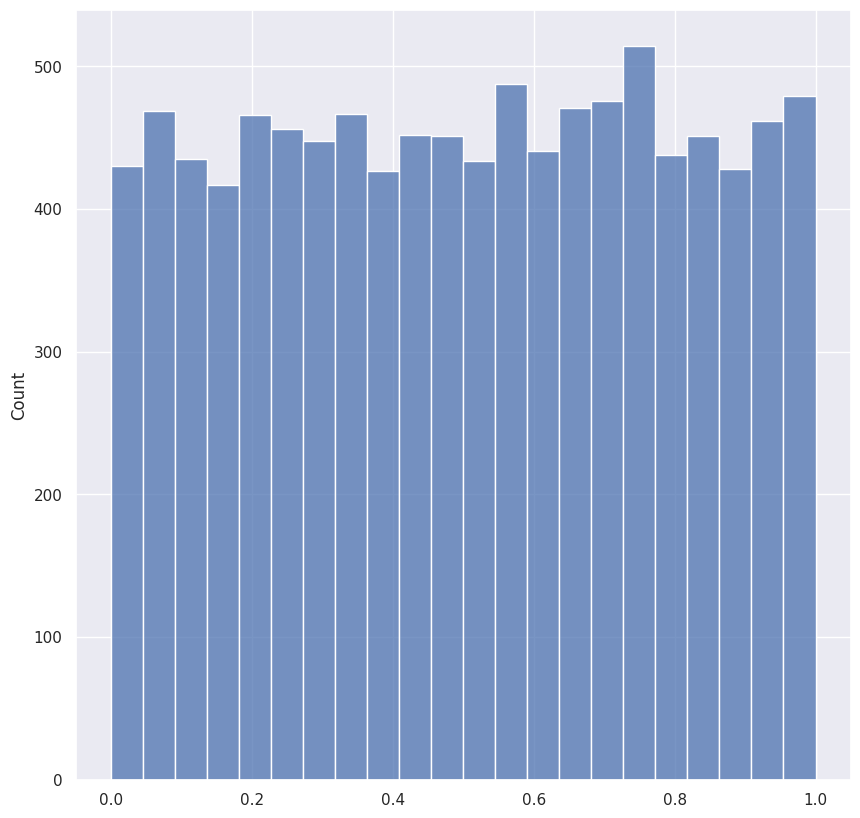

In [10]:
# Проведем бутстрап

def bootstrap_aa(n_bootstrap: int = 10_000,
                 B: int = 500,
) -> List:
    pvalues = []
    for _ in range(n_bootstrap):
        group_2 = df_aa[df_aa['exp_group'] == 2]['ctr'].sample(B, replace=False).tolist()
        group_3 = df_aa[df_aa['exp_group'] == 3]['ctr'].sample(B, replace=False).tolist()
        pvalues.append(stats.ttest_ind(group_2, group_3, equal_var=False)[1])

    return pvalues

pvalues = bootstrap_aa()
sns.histplot(pvalues)

In [11]:
sum(np.array(pvalues)<0.05)/10000

0.0475